In [1]:
#---------------------------------
#Image Processing and Machine Vision
#Team Inception
#Retinal Vessel Segmentation
#---------------------------------

In [2]:
!pip install -U -q segmentation-models --user

from PIL import Image
import numpy as np 
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import matplotlib.pyplot as plt 
import tensorflow_io as tfio
import tensorflow as tf


root = '../input/retinal-vessel-segmentation'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


In [3]:
input_data = os.path.join(root, 'DRIVE/training/images')
images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


target_data = os.path.join(root, 'DRIVE/training/1st_manual')
masks = sorted(
    [
        os.path.join(target_data, fname)
        for fname in os.listdir(target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

print("Number of samples:", len(images), len(masks))
for input_path, target_path in zip(images[:10], masks[:10]):
    print(input_path[-31:], "|", target_path[-34:])

Number of samples: 20 20
training/images/21_training.tif | training/1st_manual/21_manual1.gif
training/images/22_training.tif | training/1st_manual/22_manual1.gif
training/images/23_training.tif | training/1st_manual/23_manual1.gif
training/images/24_training.tif | training/1st_manual/24_manual1.gif
training/images/25_training.tif | training/1st_manual/25_manual1.gif
training/images/26_training.tif | training/1st_manual/26_manual1.gif
training/images/27_training.tif | training/1st_manual/27_manual1.gif
training/images/28_training.tif | training/1st_manual/28_manual1.gif
training/images/29_training.tif | training/1st_manual/29_manual1.gif
training/images/30_training.tif | training/1st_manual/30_manual1.gif


In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 12

def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.io.decode_gif(image) # out: (1, h, w, 3)
        image = tf.squeeze(image) # out: (h, w, 3)
        image = tf.image.rgb_to_grayscale(image) # out: (h, w, 1)
        image = tf.divide(image, 128)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.int32)
    else:
        image = tfio.experimental.image.decode_tiff(image) # out: (h, w, 4)
        image = image[:,:,:3] # out: (h, w, 3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.
    return image

def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask  = read_files(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset

train_dataset = data_generator(images, masks)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>

In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images) 
    plt.figure(figsize=(20, 20))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()

(12, 512, 512, 3) (12, 512, 512, 1)
0 1
[0 1]


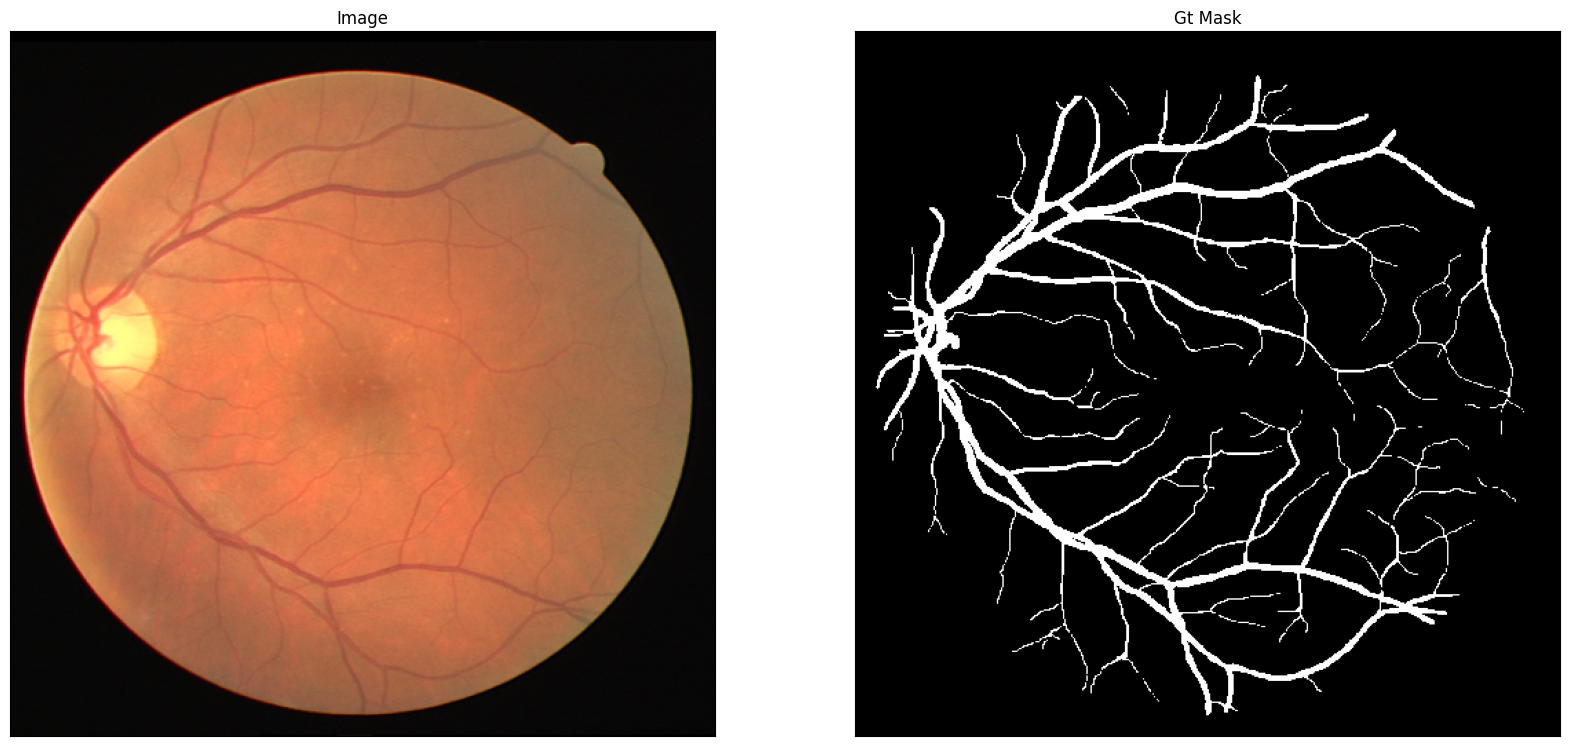

In [6]:
image, mask = next(iter(train_dataset.take(1))) 
print(image.shape, mask.shape)

for (img, msk) in zip(image[:1], mask[:1]):
    print(mask.numpy().min(), mask.numpy().max())
    print(np.unique(mask.numpy()))
    visualize(
        image=img.numpy(),
        gt_mask=msk.numpy(),
    )

In [7]:
'''from tensorflow import keras 

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
BACKBONE   = 'efficientnetb0'
n_classes  = 1 
activation = 'sigmoid' 
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
# model.summary(line_length=110)'''

"from tensorflow import keras \n\n# Free up RAM in case the model definition cells were run multiple times\nkeras.backend.clear_session()\nBACKBONE   = 'efficientnetb0'\nn_classes  = 1 \nactivation = 'sigmoid' \nmodel = sm.Unet(BACKBONE, classes=n_classes, activation=activation)\n# model.summary(line_length=110)"

In [8]:
# custom model

In [9]:
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Conv2D, Multiply, concatenate

class CustomUnetBase:
    def __init__(self, *args, dropout_rate=0.5, **kwargs):
        self.dropout_rate = dropout_rate

    def structured_dropout_conv_block(self, x, filters, kernel_size=(3, 3)):
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = Dropout(self.dropout_rate)(x)
        return x

    def spatial_attention_module(self, x):
        max_pooling = GlobalMaxPooling2D()(x)
        avg_pooling = GlobalAveragePooling2D()(x)
        combined_pooling = concatenate([max_pooling, avg_pooling], axis=-1)

        attention = Conv2D(1, (1, 1), activation='sigmoid')(combined_pooling)

        return Multiply()([x, attention])

class CustomUnet(tf.keras.Model):
    def __init__(self, *args, dropout_rate=0.5, **kwargs):
        super(CustomUnet, self).__init__()
        self.custom_unet_base = CustomUnetBase(*args, dropout_rate=dropout_rate, **kwargs)
        kwargs.pop('dropout_rate', None)  # Remove dropout_rate from kwargs
        self.unet_model = sm.Unet(*args, **kwargs)

    def decoder_block(self, x, skip, filters, block_number):
        x = self.unet_model.decoder_block(x, skip, filters, block_number)
        x = self.custom_unet_base.structured_dropout_conv_block(x, filters)
        x = self.custom_unet_base.spatial_attention_module(x)

        # Skip connection
        skip = Conv2D(filters, (1, 1), padding='same')(skip)
        x = concatenate([x, skip], axis=-1)

        return x

    def call(self, inputs):
        return self.unet_model(inputs)

# Clear previous session
tf.keras.backend.clear_session()

# Create the custom Unet model
model = CustomUnet('efficientnetb0', classes=1, activation='sigmoid', dropout_rate=0.5)
model.build((None, None, None, 3))  # Build the model with a specific input shape
model.summary()

16804768/16804768 [==============================] - 0s 0us/step
Model: "custom_unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, None, None, 1)     10115501  
                                                                 
Total params: 10,115,501
Trainable params: 10,071,501
Non-trainable params: 44,000
_________________________________________________________________


In [10]:
from tensorflow import keras
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=10):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
        self.f1_scores = []
        self.mcc_scores = []
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            f1 = logs.get('f1_metric', 0.0)
            mcc = logs.get('mcc_metric', 0.0)
            self.f1_scores.append(f1)
            self.mcc_scores.append(mcc)
            if epoch and epoch % (self.epoch_interval*5) == 0:
                self.show_predictions(self.dataset)
                print ('\n Sample Output after {} epochs\n'.format(epoch+1))

In [11]:
'''# define optomizer
optim = keras.optimizers.Adam(0.0001)
bce   = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics)

model.fit(
    train_dataset, 
    callbacks=[DisplayCallback(train_dataset)],
    epochs=200
)'''

'# define optomizer\noptim = keras.optimizers.Adam(0.0001)\nbce   = keras.losses.BinaryCrossentropy()\nmetrics = ["accuracy"]\n\n# compile keras model with defined optimozer, loss and metrics\nmodel.compile(optim, bce, metrics)\n\nmodel.fit(\n    train_dataset, \n    callbacks=[DisplayCallback(train_dataset)],\n    epochs=200\n)'

Epoch 1/420
2/2 [==============================] - 72s 6s/step - loss: 0.5899 - accuracy: 0.7450 - f1_metric: 0.1514 - mcc_metric: 0.0369
Epoch 2/420
2/2 [==============================] - 1s 436ms/step - loss: 0.5585 - accuracy: 0.7691 - f1_metric: 0.1942 - mcc_metric: 0.0937
Epoch 3/420
2/2 [==============================] - 1s 422ms/step - loss: 0.5319 - accuracy: 0.7892 - f1_metric: 0.2383 - mcc_metric: 0.1497
Epoch 4/420
2/2 [==============================] - 1s 435ms/step - loss: 0.5082 - accuracy: 0.8079 - f1_metric: 0.2837 - mcc_metric: 0.2061
Epoch 5/420
2/2 [==============================] - 1s 435ms/step - loss: 0.4873 - accuracy: 0.8237 - f1_metric: 0.3263 - mcc_metric: 0.2578
Epoch 6/420
2/2 [==============================] - 1s 437ms/step - loss: 0.4678 - accuracy: 0.8373 - f1_metric: 0.3655 - mcc_metric: 0.3048
Epoch 7/420
2/2 [==============================] - 1s 423ms/step - loss: 0.4497 - accuracy: 0.8485 - f1_metric: 0.4000 - mcc_metric: 0.3458
Epoch 8/420
2/2 [=====

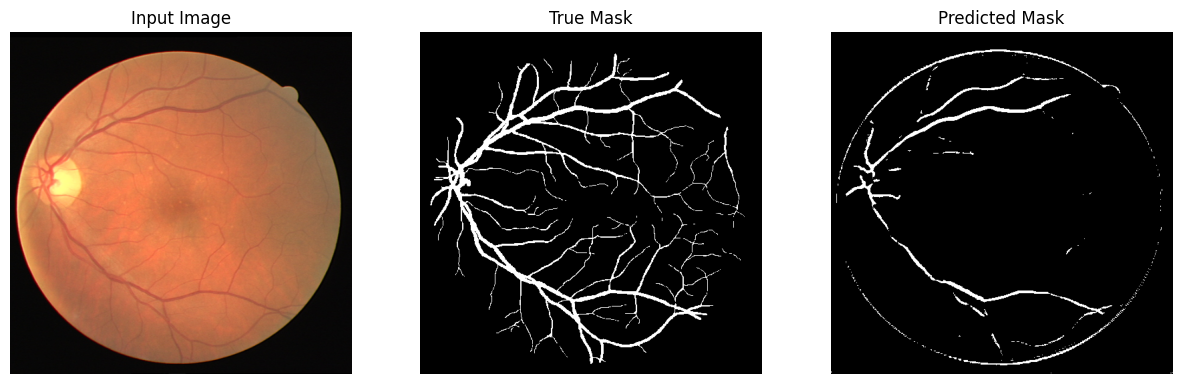


 Sample Output after 51 epochs

2/2 [==============================] - 4s 3s/step - loss: 0.1984 - accuracy: 0.9635 - f1_metric: 0.7862 - mcc_metric: 0.7661
Epoch 52/420
2/2 [==============================] - 1s 422ms/step - loss: 0.1959 - accuracy: 0.9640 - f1_metric: 0.7888 - mcc_metric: 0.7689
Epoch 53/420
2/2 [==============================] - 1s 426ms/step - loss: 0.1942 - accuracy: 0.9641 - f1_metric: 0.7892 - mcc_metric: 0.7694
Epoch 54/420
2/2 [==============================] - 1s 436ms/step - loss: 0.1916 - accuracy: 0.9647 - f1_metric: 0.7922 - mcc_metric: 0.7727
Epoch 55/420
2/2 [==============================] - 1s 423ms/step - loss: 0.1896 - accuracy: 0.9649 - f1_metric: 0.7931 - mcc_metric: 0.7738
Epoch 56/420
2/2 [==============================] - 1s 424ms/step - loss: 0.1877 - accuracy: 0.9652 - f1_metric: 0.7945 - mcc_metric: 0.7754
Epoch 57/420
2/2 [==============================] - 1s 436ms/step - loss: 0.1859 - accuracy: 0.9655 - f1_metric: 0.7962 - mcc_metric: 0.7

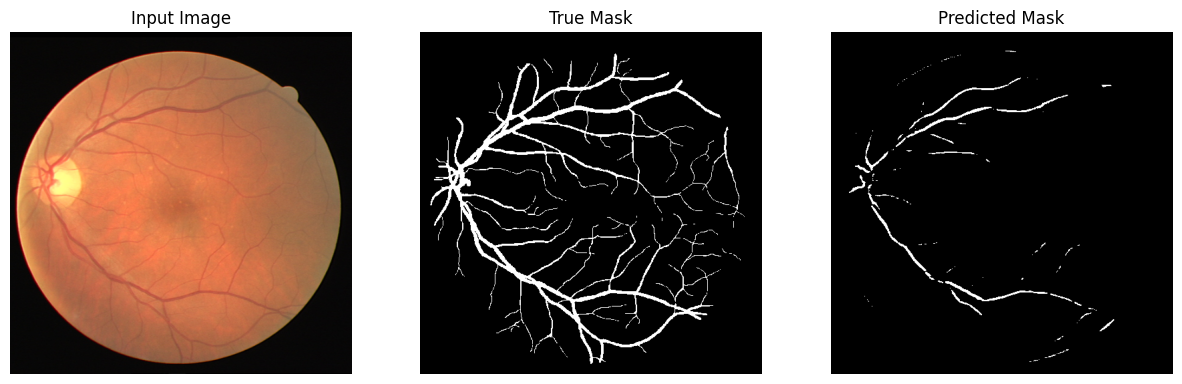


 Sample Output after 101 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.1322 - accuracy: 0.9724 - f1_metric: 0.8355 - mcc_metric: 0.8208
Epoch 102/420
2/2 [==============================] - 1s 436ms/step - loss: 0.1312 - accuracy: 0.9726 - f1_metric: 0.8368 - mcc_metric: 0.8222
Epoch 103/420
2/2 [==============================] - 1s 449ms/step - loss: 0.1303 - accuracy: 0.9729 - f1_metric: 0.8385 - mcc_metric: 0.8241
Epoch 104/420
2/2 [==============================] - 1s 436ms/step - loss: 0.1293 - accuracy: 0.9730 - f1_metric: 0.8389 - mcc_metric: 0.8245
Epoch 105/420
2/2 [==============================] - 1s 439ms/step - loss: 0.1286 - accuracy: 0.9731 - f1_metric: 0.8392 - mcc_metric: 0.8249
Epoch 106/420
2/2 [==============================] - 1s 436ms/step - loss: 0.1277 - accuracy: 0.9731 - f1_metric: 0.8399 - mcc_metric: 0.8256
Epoch 107/420
2/2 [==============================] - 1s 434ms/step - loss: 0.1277 - accuracy: 0.9729 - f1_metric: 0.8381 - mcc_metr

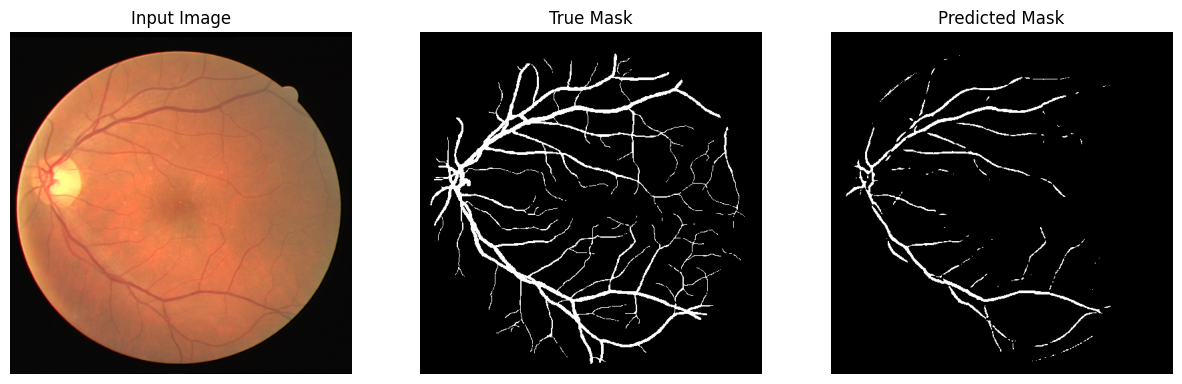


 Sample Output after 151 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0996 - accuracy: 0.9777 - f1_metric: 0.8681 - mcc_metric: 0.8564
Epoch 152/420
2/2 [==============================] - 1s 425ms/step - loss: 0.1002 - accuracy: 0.9771 - f1_metric: 0.8644 - mcc_metric: 0.8523
Epoch 153/420
2/2 [==============================] - 1s 424ms/step - loss: 0.0988 - accuracy: 0.9777 - f1_metric: 0.8681 - mcc_metric: 0.8563
Epoch 154/420
2/2 [==============================] - 1s 422ms/step - loss: 0.0984 - accuracy: 0.9778 - f1_metric: 0.8690 - mcc_metric: 0.8574
Epoch 155/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0981 - accuracy: 0.9778 - f1_metric: 0.8687 - mcc_metric: 0.8571
Epoch 156/420
2/2 [==============================] - 1s 437ms/step - loss: 0.0983 - accuracy: 0.9775 - f1_metric: 0.8667 - mcc_metric: 0.8549
Epoch 157/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0977 - accuracy: 0.9776 - f1_metric: 0.8670 - mcc_metr

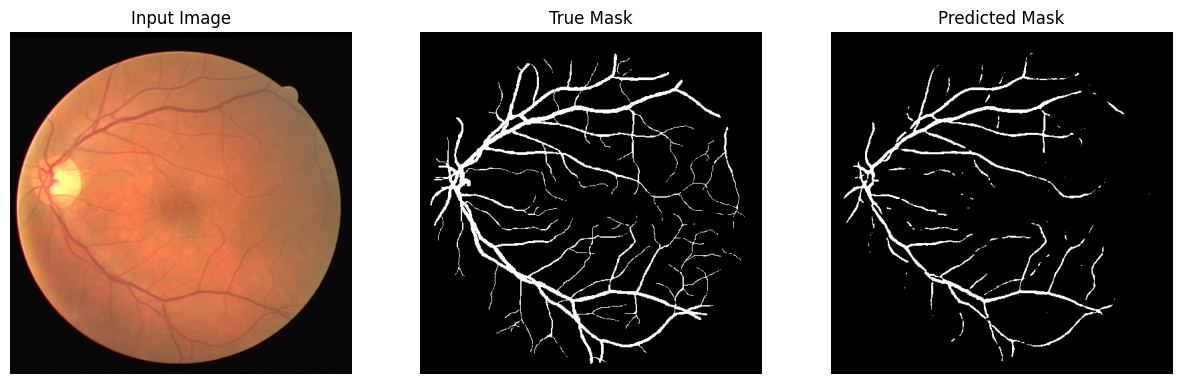


 Sample Output after 201 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0811 - accuracy: 0.9806 - f1_metric: 0.8866 - mcc_metric: 0.8765
Epoch 202/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0808 - accuracy: 0.9805 - f1_metric: 0.8857 - mcc_metric: 0.8755
Epoch 203/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0796 - accuracy: 0.9813 - f1_metric: 0.8903 - mcc_metric: 0.8804
Epoch 204/420
2/2 [==============================] - 1s 448ms/step - loss: 0.0793 - accuracy: 0.9813 - f1_metric: 0.8896 - mcc_metric: 0.8797
Epoch 205/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0790 - accuracy: 0.9814 - f1_metric: 0.8906 - mcc_metric: 0.8809
Epoch 206/420
2/2 [==============================] - 1s 424ms/step - loss: 0.0786 - accuracy: 0.9815 - f1_metric: 0.8920 - mcc_metric: 0.8823
Epoch 207/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0787 - accuracy: 0.9812 - f1_metric: 0.8896 - mcc_metr

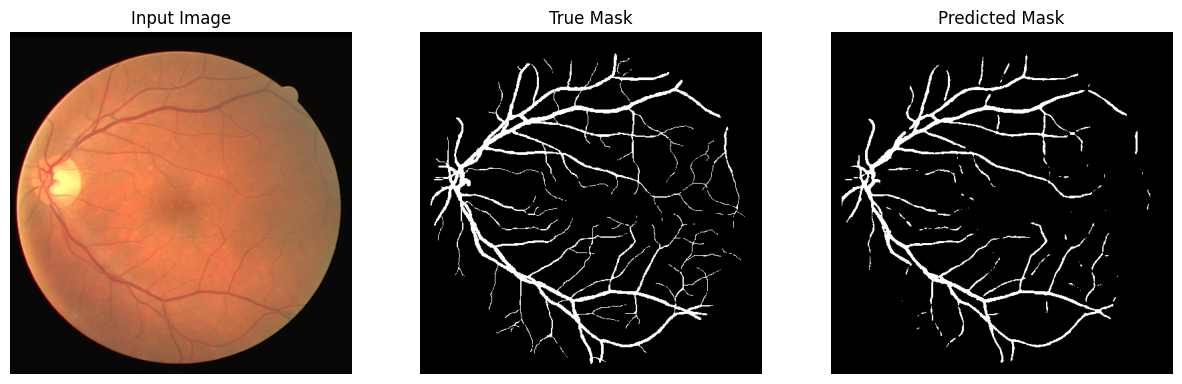


 Sample Output after 251 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0672 - accuracy: 0.9836 - f1_metric: 0.9046 - mcc_metric: 0.8961
Epoch 252/420
2/2 [==============================] - 1s 422ms/step - loss: 0.0677 - accuracy: 0.9832 - f1_metric: 0.9018 - mcc_metric: 0.8930
Epoch 253/420
2/2 [==============================] - 1s 437ms/step - loss: 0.0687 - accuracy: 0.9824 - f1_metric: 0.8971 - mcc_metric: 0.8878
Epoch 254/420
2/2 [==============================] - 1s 422ms/step - loss: 0.0671 - accuracy: 0.9834 - f1_metric: 0.9030 - mcc_metric: 0.8943
Epoch 255/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0660 - accuracy: 0.9840 - f1_metric: 0.9074 - mcc_metric: 0.8990
Epoch 256/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0662 - accuracy: 0.9837 - f1_metric: 0.9048 - mcc_metric: 0.8963
Epoch 257/420
2/2 [==============================] - 1s 422ms/step - loss: 0.0662 - accuracy: 0.9836 - f1_metric: 0.9039 - mcc_metr

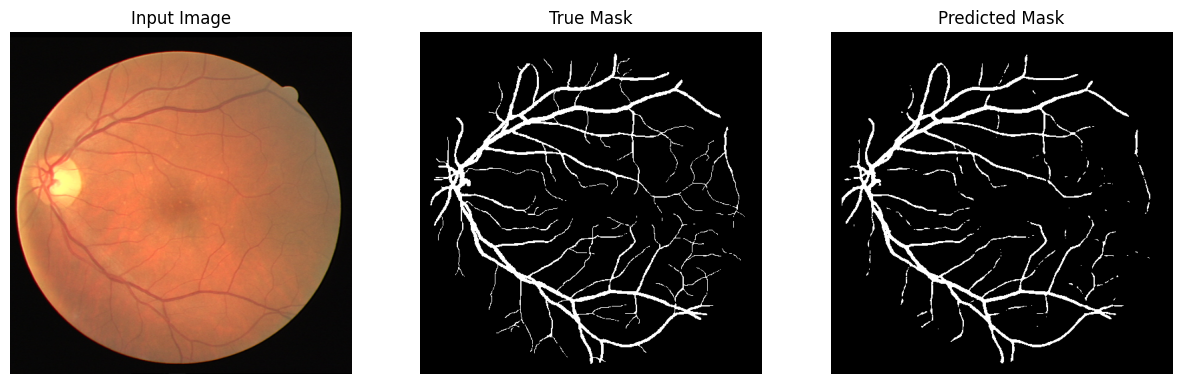


 Sample Output after 301 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0574 - accuracy: 0.9858 - f1_metric: 0.9174 - mcc_metric: 0.9098
Epoch 302/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0566 - accuracy: 0.9863 - f1_metric: 0.9213 - mcc_metric: 0.9141
Epoch 303/420
2/2 [==============================] - 1s 422ms/step - loss: 0.0568 - accuracy: 0.9861 - f1_metric: 0.9202 - mcc_metric: 0.9130
Epoch 304/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0566 - accuracy: 0.9861 - f1_metric: 0.9198 - mcc_metric: 0.9125
Epoch 305/420
2/2 [==============================] - 1s 440ms/step - loss: 0.0571 - accuracy: 0.9856 - f1_metric: 0.9174 - mcc_metric: 0.9099
Epoch 306/420
2/2 [==============================] - 1s 437ms/step - loss: 0.0562 - accuracy: 0.9862 - f1_metric: 0.9206 - mcc_metric: 0.9133
Epoch 307/420
2/2 [==============================] - 1s 425ms/step - loss: 0.0559 - accuracy: 0.9865 - f1_metric: 0.9223 - mcc_metr

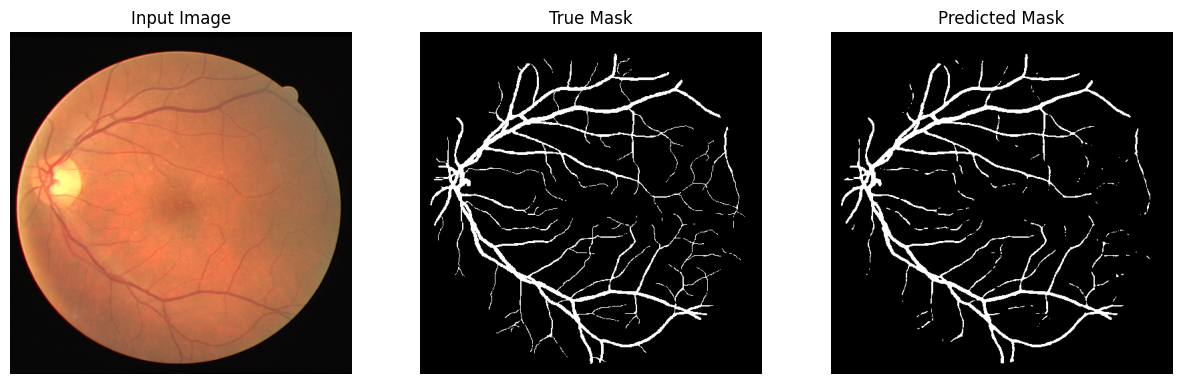


 Sample Output after 351 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0493 - accuracy: 0.9881 - f1_metric: 0.9318 - mcc_metric: 0.9256
Epoch 352/420
2/2 [==============================] - 1s 425ms/step - loss: 0.0492 - accuracy: 0.9880 - f1_metric: 0.9314 - mcc_metric: 0.9251
Epoch 353/420
2/2 [==============================] - 1s 424ms/step - loss: 0.0490 - accuracy: 0.9881 - f1_metric: 0.9320 - mcc_metric: 0.9258
Epoch 354/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0492 - accuracy: 0.9879 - f1_metric: 0.9311 - mcc_metric: 0.9248
Epoch 355/420
2/2 [==============================] - 1s 438ms/step - loss: 0.0486 - accuracy: 0.9883 - f1_metric: 0.9333 - mcc_metric: 0.9272
Epoch 356/420
2/2 [==============================] - 1s 425ms/step - loss: 0.0494 - accuracy: 0.9876 - f1_metric: 0.9283 - mcc_metric: 0.9218
Epoch 357/420
2/2 [==============================] - 1s 425ms/step - loss: 0.0493 - accuracy: 0.9877 - f1_metric: 0.9301 - mcc_metr

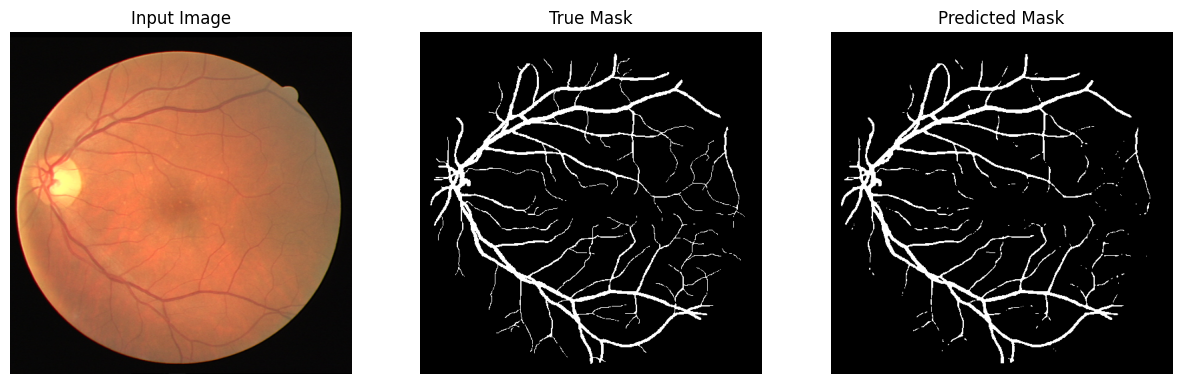


 Sample Output after 401 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0435 - accuracy: 0.9894 - f1_metric: 0.9398 - mcc_metric: 0.9342
Epoch 402/420
2/2 [==============================] - 1s 424ms/step - loss: 0.0443 - accuracy: 0.9889 - f1_metric: 0.9366 - mcc_metric: 0.9308
Epoch 403/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0435 - accuracy: 0.9895 - f1_metric: 0.9407 - mcc_metric: 0.9352
Epoch 404/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0430 - accuracy: 0.9896 - f1_metric: 0.9406 - mcc_metric: 0.9351
Epoch 405/420
2/2 [==============================] - 1s 424ms/step - loss: 0.0432 - accuracy: 0.9894 - f1_metric: 0.9400 - mcc_metric: 0.9345
Epoch 406/420
2/2 [==============================] - 1s 424ms/step - loss: 0.0431 - accuracy: 0.9895 - f1_metric: 0.9405 - mcc_metric: 0.9350
Epoch 407/420
2/2 [==============================] - 1s 428ms/step - loss: 0.0423 - accuracy: 0.9900 - f1_metric: 0.9433 - mcc_metr

In [12]:
from sklearn.metrics import f1_score, matthews_corrcoef

# define optimizer
optim = keras.optimizers.Adam(0.0001)
bce = keras.losses.BinaryCrossentropy()

def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1

def mcc_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * y_pred, 0, 1)))
    false_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * (1 - y_pred), 0, 1)))

    mcc = (true_positives * true_negatives - false_positives * false_negatives) / tf.keras.backend.sqrt(
        (true_positives + false_positives) * (true_positives + false_negatives) *
        (true_negatives + false_positives) * (true_negatives + false_negatives) + tf.keras.backend.epsilon())
    
    return mcc

# compile keras model with defined optimizer, loss, and metrics
model.compile(optim, bce, metrics=["accuracy", f1_metric, mcc_metric])
callback = DisplayCallback(train_dataset)
model.fit(
    train_dataset, 
    callbacks=[callback],
    epochs=420
)

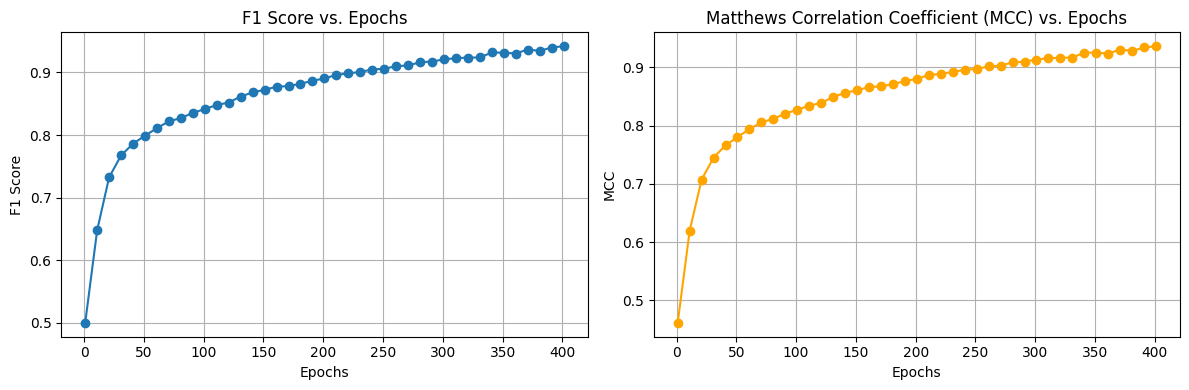

In [13]:


f1_scores = callback.f1_scores
mcc_scores = callback.mcc_scores

# Create a new list for x-axis representing each epoch
epochs = list(range(1, len(f1_scores) * 10 + 1, 10))[:len(f1_scores)]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, f1_scores, marker='o')  # Use the new epochs list
plt.title('F1 Score vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, mcc_scores, marker='o', color='orange')  # Use the new epochs list
plt.title('Matthews Correlation Coefficient (MCC) vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('MCC')
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 875ms/step


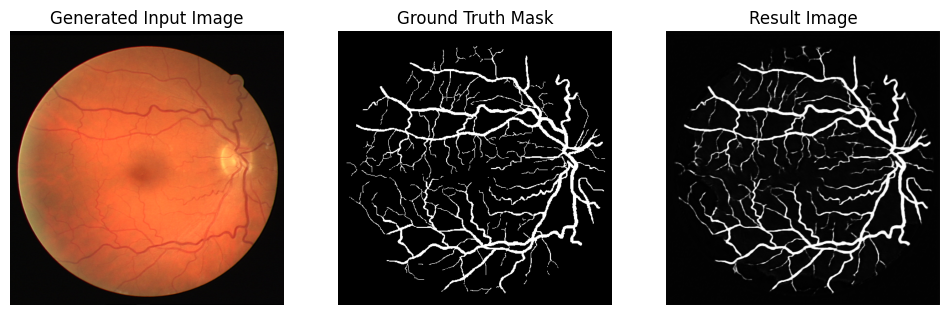

In [14]:
input_image=image[1]
ground_truth_mask=mask[1]
input_image = np.expand_dims(input_image, axis=0)

input_image = np.squeeze(input_image, axis=0)

# Plot the generated image and its ground truth mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Generated Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

# Add batch dimension to the image
input_image = np.expand_dims(input_image, axis=0)

enhanced_image = model.predict(input_image)[0]

plt.subplot(1, 3, 3)
plt.imshow(enhanced_image, cmap='gray')
plt.title('Result Image')
plt.axis('off')

plt.show()